## Introduction
The purpose of this notebook is to explore profiles of human primary T cells post-electroporation. Our main goal is to identify cells that are more likely to take up and express the plasmid. Our transfection efficiency (as defined by the frequency of GFP positive cells a day after the GFP plasmid electroporation) is relatively low (<%5) for the unstimulated population and relatively high but variable (20-70%) for the activated ones.

To see the general characteristics of these GFP positive cells, we electroporated them either in unstimulated form or two-days after bead-based activation. The next day, we stained them to profile their activation and naive/memory status. For activation, we used `CD25` (which is expected to be up-regulated upon activation) and also `CD69` (which is an early activation marker). For the naive/memory phenotype, we used the `CCR7/CD45RO` combination where `CCR7+ CD45RO+` cells are assumed to be `naive`, `CCR7+ CD45RO+` cells to be `central memory`, and `CCR7- CD45RO+` ones to be `effective memory`.

With this setup, we can also gate based on `GFP (FITC)` positivity to compare and contrast `GFP+` profiles against `GFP-` ones.

## Data preparation
Let's start with importing the frequency table from FlowJo and transforming it to a form that will allow us easily compare different populations.

In [1]:
library('readr')
library('magrittr')
library('dplyr')
library('tidyr')
library('ggplot2')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



We have three donors, two staining strategies, two electroporation conditions, and two cell states. This is how the original table looks originally:

In [2]:
raw_tbl <-
    read_tsv(
        'flow-data.csv',
        col_types=cols(
            `Sample:`=col_character(),
            `Donor`=col_factor(levels=c('Donor 30', 'Donor 31', 'Donor 33')),
            `Cell state`=col_factor(levels=c('Activated', 'Unstimulated')),
            `Electroporation`=col_factor(levels=c('no DNA', 'NDG plasmid')),
            `Staining`=col_factor(levels=c('Activation status', 'Naive status')),
            .default=col_double()
        )
    )

raw_tbl %>% head

Sample:,Donor,Cell state,Electroporation,Staining,Live | Freq. of Parent,Live/GFP+ | Freq. of Parent,Live/GFP+/CCR7+ CD45RO+ | Freq. of Parent,Live/GFP+/CCR7+ CD45RO- | Freq. of Parent,Live/GFP+/CCR7- CD45RO+ | Freq. of Parent,⋯,Live/GFP-/CD25- CD69+ | Freq. of Parent,Live/GFP-/CD25- CD69- | Freq. of Parent,Live/CCR7+ CD45RO+ | Freq. of Parent,Live/CCR7+ CD45RO- | Freq. of Parent,Live/CCR7- CD45RO+ | Freq. of Parent,Live/CCR7- CD45RO- | Freq. of Parent,Live/CD25+ CD69+ | Freq. of Parent,Live/CD25+ CD69- | Freq. of Parent,Live/CD25- CD69+ | Freq. of Parent,Live/CD25- CD69- | Freq. of Parent
30A-DNA-act.fcs,Donor 30,Activated,NDG plasmid,Activation status,18.5,20.800,10.40,0.81,81.5,⋯,11.000,1.50,2.180,0.17000,81.9,15.70,84.10,4.95,9.690,1.22
30A-DNA-naive-rerun.fcs,Donor 30,Activated,NDG plasmid,Naive status,15.6,21.400,75.10,13.10,11.0,⋯,0.250,17.70,62.500,19.70000,14.9,2.97,24.20,59.80,0.980,15.00
30A-noDNA-act.fcs,Donor 30,Activated,no DNA,Activation status,31.1,0.064,0.00,0.00,95.0,⋯,11.900,1.41,0.260,0.00000,81.8,18.00,82.20,4.46,11.900,1.41
30A-noDNA-naive.fcs,Donor 30,Activated,no DNA,Naive status,33.2,0.051,70.60,11.80,11.8,⋯,0.270,15.10,65.800,18.90000,13.1,2.21,17.10,67.50,0.270,15.10
30U-DNA-act.fcs,Donor 30,Unstimulated,NDG plasmid,Activation status,57.7,0.750,1.39,0.23,32.3,⋯,11.600,63.20,0.033,0.00173,18.5,81.40,8.42,17.00,11.700,62.90
30U-DNA-naive.fcs,Donor 30,Unstimulated,NDG plasmid,Naive status,57.0,1.000,47.90,12.50,31.2,⋯,0.048,31.40,35.100,32.10000,29.5,3.32,1.67,67.00,0.077,31.20


In [3]:
names(raw_tbl)

[1] "Sample:"                                  
 [2] "Donor"                                    
 [3] "Cell state"                               
 [4] "Electroporation"                          
 [5] "Staining"                                 
 [6] "Live | Freq. of Parent"                   
 [7] "Live/GFP+ | Freq. of Parent"              
 [8] "Live/GFP+/CCR7+ CD45RO+ | Freq. of Parent"
 [9] "Live/GFP+/CCR7+ CD45RO- | Freq. of Parent"
[10] "Live/GFP+/CCR7- CD45RO+ | Freq. of Parent"
[11] "Live/GFP+/CCR7- CD45RO- | Freq. of Parent"
[12] "Live/GFP+/CD25+ CD69+ | Freq. of Parent"  
[13] "Live/GFP+/CD25+ CD69- | Freq. of Parent"  
[14] "Live/GFP+/CD25- CD69+ | Freq. of Parent"  
[15] "Live/GFP+/CD25- CD69- | Freq. of Parent"  
[16] "Live/GFP- | Freq. of Parent"              
[17] "Live/GFP-/CCR7+ CD45RO+ | Freq. of Parent"
[18] "Live/GFP-/CCR7+ CD45RO- | Freq. of Parent"
[19] "Live/GFP-/CCR7- CD45RO+ | Freq. of Parent"
[20] "Live/GFP-/CCR7- CD45RO- | Freq. of Parent"
[21] "Live/GFP-/CD25+ CD69+ | Freq. of Parent"  
[22] "Live/GFP-/CD25+ CD69- | Freq. of Parent"  
[23] "Live/GFP-/CD25- CD69+ | Freq. of Parent"  
[24] "Live/GFP-/CD25- CD69- | Freq. of Parent"  
[25] "Live/CCR7+ CD45RO+ | Freq. of Parent"     
[26] "Live/CCR7+ CD45RO- | Freq. of Parent"     
[27] "Live/CCR7- CD45RO+ | Freq. of Parent"     
[28] "Live/CCR7- CD45RO- | Freq. of Parent"     
[29] "Live/CD25+ CD69+ | Freq. of Parent"       
[30] "Live/CD25+ CD69- | Freq. of Parent"       
[31] "Live/CD25- CD69+ | Freq. of Parent"       
[32] "Live/CD25- CD69- | Freq. of Parent"

We want to transform it so that each observation per population becomes a row:

In [4]:
flow_data <-
    raw_tbl %>%
    gather(
        key='Population',
        value='Freq_of_Parent',
        factor_key=TRUE,
        `Live/GFP+ | Freq. of Parent`:`Live/CD25- CD69- | Freq. of Parent`
    )

flow_data

Sample:,Donor,Cell state,Electroporation,Staining,Live | Freq. of Parent,Population,Freq_of_Parent
30A-DNA-act.fcs,Donor 30,Activated,NDG plasmid,Activation status,18.5,Live/GFP+ | Freq. of Parent,20.800
30A-DNA-naive-rerun.fcs,Donor 30,Activated,NDG plasmid,Naive status,15.6,Live/GFP+ | Freq. of Parent,21.400
30A-noDNA-act.fcs,Donor 30,Activated,no DNA,Activation status,31.1,Live/GFP+ | Freq. of Parent,0.064
30A-noDNA-naive.fcs,Donor 30,Activated,no DNA,Naive status,33.2,Live/GFP+ | Freq. of Parent,0.051
30U-DNA-act.fcs,Donor 30,Unstimulated,NDG plasmid,Activation status,57.7,Live/GFP+ | Freq. of Parent,0.750
30U-DNA-naive.fcs,Donor 30,Unstimulated,NDG plasmid,Naive status,57.0,Live/GFP+ | Freq. of Parent,1.000
30U-noDNA-act-rerun.fcs,Donor 30,Unstimulated,no DNA,Activation status,79.0,Live/GFP+ | Freq. of Parent,0.070
30U-noDNA-naive.fcs,Donor 30,Unstimulated,no DNA,Naive status,81.0,Live/GFP+ | Freq. of Parent,0.080
31A-DNA-act.fcs,Donor 31,Activated,NDG plasmid,Activation status,16.5,Live/GFP+ | Freq. of Parent,10.100
31A-DNA-naive.fcs,Donor 31,Activated,NDG plasmid,Naive status,17.2,Live/GFP+ | Freq. of Parent,10.200


## GFP positivity
Let's start with checking the transfection efficiency for each of the conditions. The `no DNA` serves as negative control.

In [5]:
head(flow_data)

Sample:,Donor,Cell state,Electroporation,Staining,Live | Freq. of Parent,Population,Freq_of_Parent
30A-DNA-act.fcs,Donor 30,Activated,NDG plasmid,Activation status,18.5,Live/GFP+ | Freq. of Parent,20.800
30A-DNA-naive-rerun.fcs,Donor 30,Activated,NDG plasmid,Naive status,15.6,Live/GFP+ | Freq. of Parent,21.400
30A-noDNA-act.fcs,Donor 30,Activated,no DNA,Activation status,31.1,Live/GFP+ | Freq. of Parent,0.064
30A-noDNA-naive.fcs,Donor 30,Activated,no DNA,Naive status,33.2,Live/GFP+ | Freq. of Parent,0.051
30U-DNA-act.fcs,Donor 30,Unstimulated,NDG plasmid,Activation status,57.7,Live/GFP+ | Freq. of Parent,0.750
30U-DNA-naive.fcs,Donor 30,Unstimulated,NDG plasmid,Naive status,57.0,Live/GFP+ | Freq. of Parent,1.000


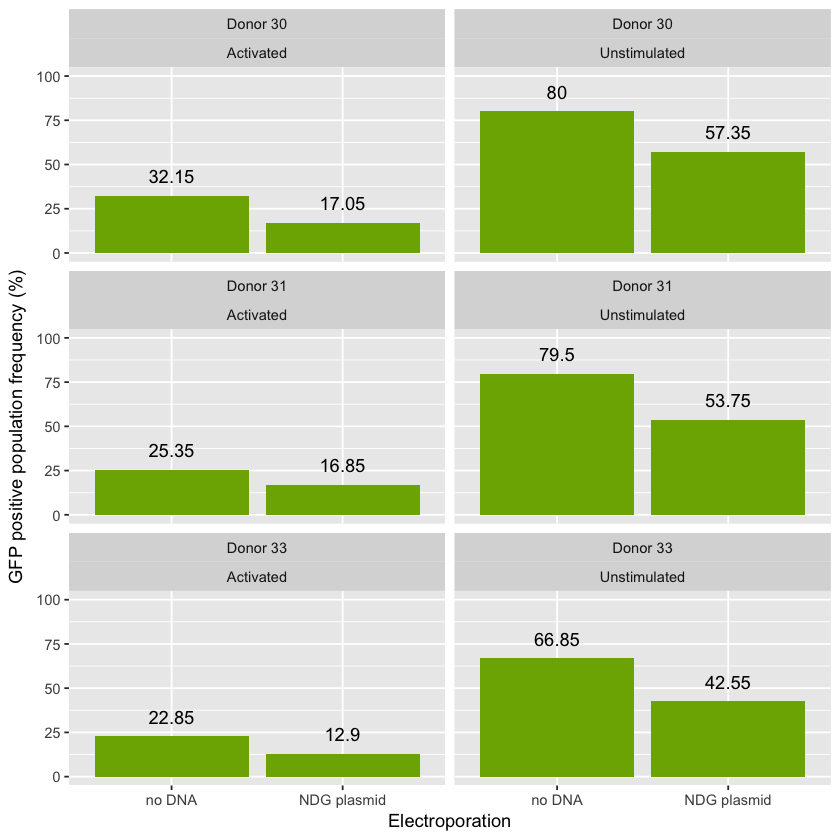

In [6]:
flow_data %>%
    filter(`Population` == 'Live/GFP+ | Freq. of Parent') %>%
    group_by(`Donor`, `Cell state`, `Electroporation`) %>%
    summarize(
        `GFP+`=mean(`Freq_of_Parent`),
        `Live`=mean(`Live | Freq. of Parent`)
    ) %>%
    ggplot(aes(x=`Electroporation`, y=`Live`)) +
        geom_col(fill="#7cae00") +
        geom_text(aes(label=`Live`), vjust=-1) +
        facet_wrap(~`Donor`+`Cell state`, ncol=2) +
        ylab('GFP positive population frequency (%)') +
        ylim(0, 100)

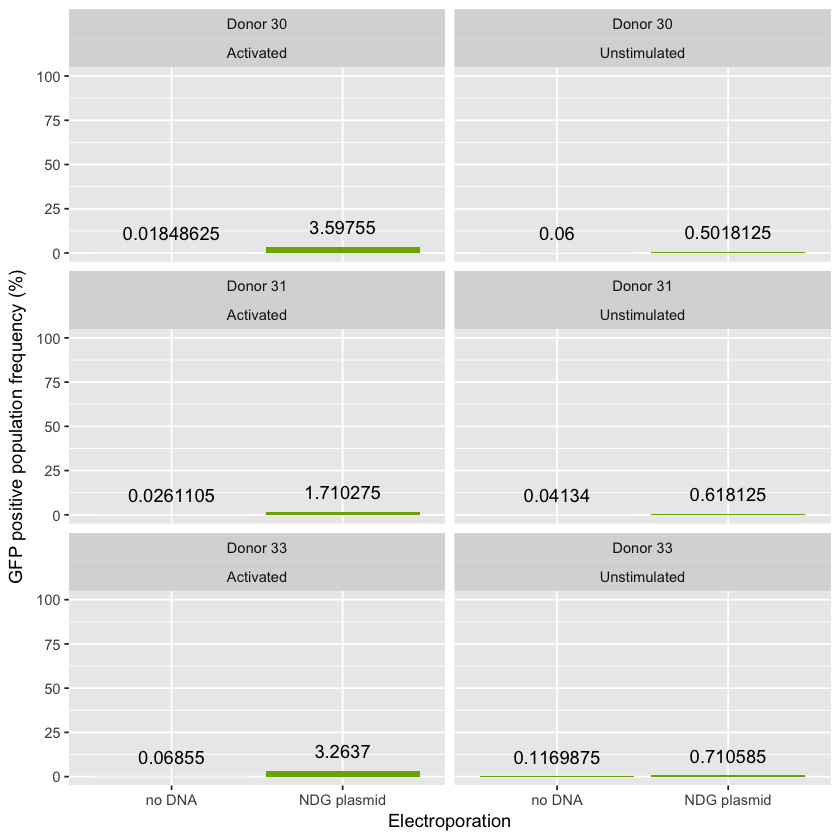

In [7]:
flow_data %>%
    filter(`Population` == 'Live/GFP+ | Freq. of Parent') %>%
    group_by(`Donor`, `Cell state`, `Electroporation`) %>%
    summarize(
        `GFP+`=mean(`Freq_of_Parent`),
        `Live`=mean(`Live | Freq. of Parent`),
        `Normalized_GFP+`=(mean(`Freq_of_Parent`)/100.0)*mean(`Live | Freq. of Parent`)
    ) %>%
    ggplot(aes(x=`Electroporation`, y=`Normalized_GFP+`)) +
        geom_col(fill="#7cae00") +
        geom_text(aes(label=`Normalized_GFP+`), vjust=-1) +
        facet_wrap(~`Donor`+`Cell state`, ncol=2) +
        ylab('GFP positive population frequency (%)') +
        ylim(0, 100)

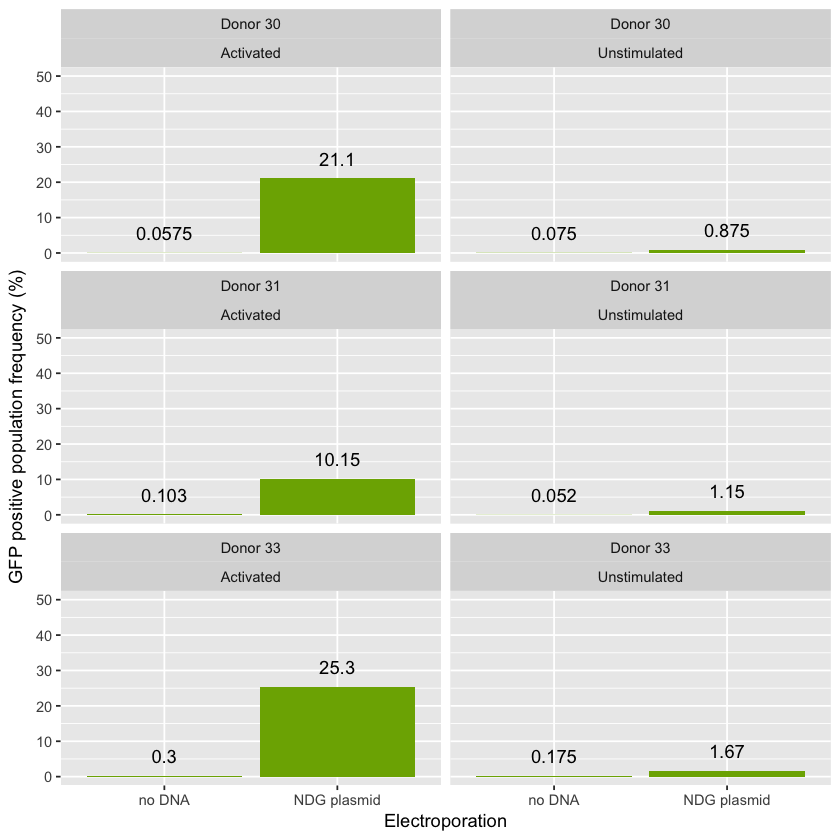

In [8]:
flow_data %>%
    filter(`Population` == 'Live/GFP+ | Freq. of Parent') %>%
    group_by(`Donor`, `Cell state`, `Electroporation`) %>%
    summarize(
        `GFP+`=mean(`Freq_of_Parent`)
    ) %>%
    ggplot(aes(x=`Electroporation`, y=`GFP+`)) +
        geom_col(fill="#7cae00") +
        geom_text(aes(label=`GFP+`), vjust=-1) +
        facet_wrap(~`Donor`+`Cell state`, ncol=2) +
        ylab('GFP positive population frequency (%)') +
        ylim(0, 50)

## Overall population comparisons

Looks like the electroporation did work. Before diving into the detailed comparisons, let's compare `no DNA` and `NDG plasmid` conditions and see if their activation and naive/memory statuses are different. Normally, we don't expect any differences across these two conditions but if there is any difference, it would imply that we are probably killing more of one phenotypic population.

### Overall population - activation markers

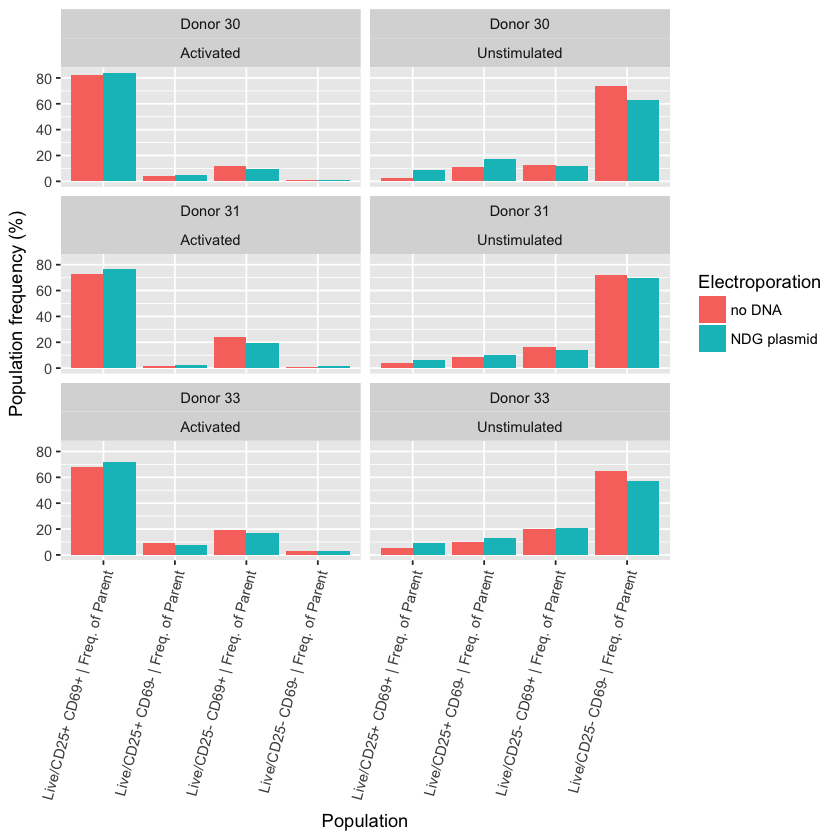

In [9]:
flow_data %>%
    filter(
        `Staining` == 'Activation status',
        `Population` %in% c(
            'Live/CD25+ CD69+ | Freq. of Parent',
            'Live/CD25+ CD69- | Freq. of Parent',
            'Live/CD25- CD69+ | Freq. of Parent',
            'Live/CD25- CD69- | Freq. of Parent'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`Electroporation`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`+`Cell state`, ncol=2) +
        ylab('Population frequency (%)') +
        theme(axis.text.x=element_text(angle=75, hjust=1))

There are some differences across populations but we don't see a huge shift in any of the populations. In the activated cells, the plasmid electroporation seem to favor `CD25+ CD69+` cells only a bit and in the unstimulated ones, `CD25- CD69-` cells seem to be relatively more prevalant compared to NDG plasmid.

### Overall population - naive/memory phenotype

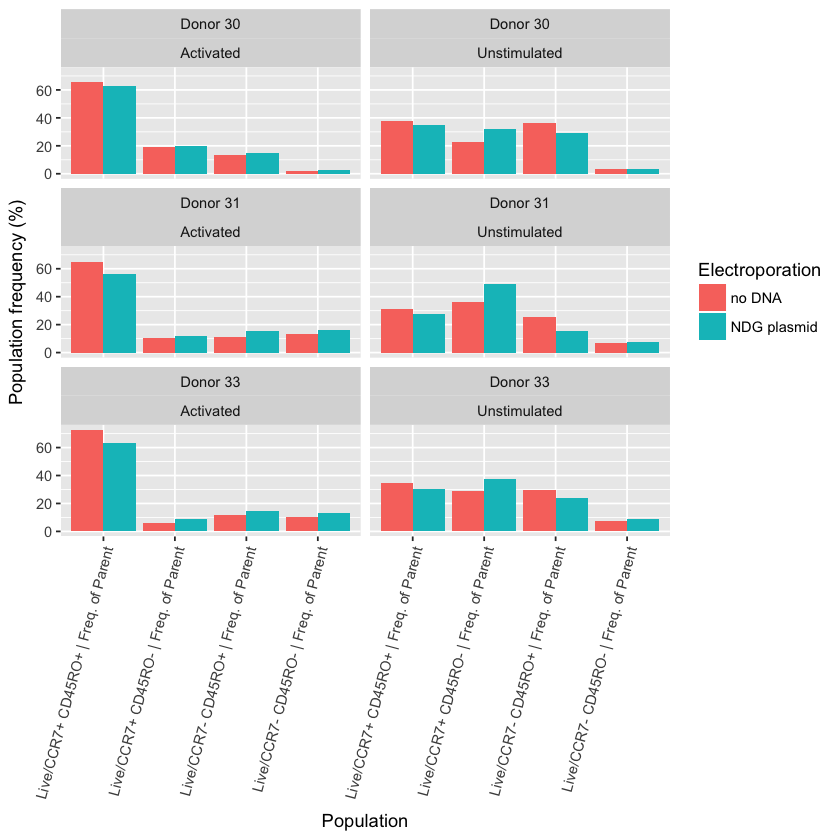

In [10]:
flow_data %>%
    filter(
        `Staining` == 'Naive status',
        `Population` %in% c(
            'Live/CCR7+ CD45RO+ | Freq. of Parent',
            'Live/CCR7- CD45RO+ | Freq. of Parent',
            'Live/CCR7+ CD45RO- | Freq. of Parent',
            'Live/CCR7- CD45RO- | Freq. of Parent'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`Electroporation`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`+`Cell state`, ncol=2) +
        ylab('Population frequency (%)') +
        theme(axis.text.x=element_text(angle=75, hjust=1))

## GFP positive vs GFP negative

After making sure that nothing looks weird with our transfection and the transfected populations, let's get the data ready for comparing `GFP positive` population to `GFP negative` one. The general understanding is that if cells are happily proliferating then they are more likely to take up and express the material electroporated to them. If this is true, we expect to see more active GFP positive cells compared to negative ones and also more prevalent CM/EM phenotype within GFP positive ones.

### Data preparation

In [11]:
raw_tbl %>% head

Sample:,Donor,Cell state,Electroporation,Staining,Live | Freq. of Parent,Live/GFP+ | Freq. of Parent,Live/GFP+/CCR7+ CD45RO+ | Freq. of Parent,Live/GFP+/CCR7+ CD45RO- | Freq. of Parent,Live/GFP+/CCR7- CD45RO+ | Freq. of Parent,⋯,Live/GFP-/CD25- CD69+ | Freq. of Parent,Live/GFP-/CD25- CD69- | Freq. of Parent,Live/CCR7+ CD45RO+ | Freq. of Parent,Live/CCR7+ CD45RO- | Freq. of Parent,Live/CCR7- CD45RO+ | Freq. of Parent,Live/CCR7- CD45RO- | Freq. of Parent,Live/CD25+ CD69+ | Freq. of Parent,Live/CD25+ CD69- | Freq. of Parent,Live/CD25- CD69+ | Freq. of Parent,Live/CD25- CD69- | Freq. of Parent
30A-DNA-act.fcs,Donor 30,Activated,NDG plasmid,Activation status,18.5,20.800,10.40,0.81,81.5,⋯,11.000,1.50,2.180,0.17000,81.9,15.70,84.10,4.95,9.690,1.22
30A-DNA-naive-rerun.fcs,Donor 30,Activated,NDG plasmid,Naive status,15.6,21.400,75.10,13.10,11.0,⋯,0.250,17.70,62.500,19.70000,14.9,2.97,24.20,59.80,0.980,15.00
30A-noDNA-act.fcs,Donor 30,Activated,no DNA,Activation status,31.1,0.064,0.00,0.00,95.0,⋯,11.900,1.41,0.260,0.00000,81.8,18.00,82.20,4.46,11.900,1.41
30A-noDNA-naive.fcs,Donor 30,Activated,no DNA,Naive status,33.2,0.051,70.60,11.80,11.8,⋯,0.270,15.10,65.800,18.90000,13.1,2.21,17.10,67.50,0.270,15.10
30U-DNA-act.fcs,Donor 30,Unstimulated,NDG plasmid,Activation status,57.7,0.750,1.39,0.23,32.3,⋯,11.600,63.20,0.033,0.00173,18.5,81.40,8.42,17.00,11.700,62.90
30U-DNA-naive.fcs,Donor 30,Unstimulated,NDG plasmid,Naive status,57.0,1.000,47.90,12.50,31.2,⋯,0.048,31.40,35.100,32.10000,29.5,3.32,1.67,67.00,0.077,31.20


In [12]:
gfp_comp_data <-
    rbind(
        raw_tbl %>%
            select(
                `Donor`:`Staining`,
                `Naive: CCR7+ CD45RO-`=`Live/GFP+/CCR7+ CD45RO- | Freq. of Parent`,
                `CM: CCR7+ CD45RO+`=`Live/GFP+/CCR7+ CD45RO+ | Freq. of Parent`,
                `EM: CCR7- CD45RO+`=`Live/GFP+/CCR7- CD45RO+ | Freq. of Parent`,
                `EMRA: CCR7- CD45RO-`=`Live/GFP+/CCR7- CD45RO- | Freq. of Parent`,
                `CD25+ CD69-`=`Live/GFP+/CD25+ CD69- | Freq. of Parent`,
                `CD25+ CD69+`=`Live/GFP+/CD25+ CD69+ | Freq. of Parent`,
                `CD25- CD69+`=`Live/GFP+/CD25- CD69+ | Freq. of Parent`,
                `CD25- CD69-`=`Live/GFP+/CD25- CD69- | Freq. of Parent`
            ) %>%
            mutate(`GFP`="Positive"),
        raw_tbl %>%
            select(
                `Donor`:`Staining`,
                `Naive: CCR7+ CD45RO-`=`Live/GFP-/CCR7+ CD45RO- | Freq. of Parent`,
                `CM: CCR7+ CD45RO+`=`Live/GFP-/CCR7+ CD45RO+ | Freq. of Parent`,
                `EM: CCR7- CD45RO+`=`Live/GFP-/CCR7- CD45RO+ | Freq. of Parent`,
                `EMRA: CCR7- CD45RO-`=`Live/GFP-/CCR7- CD45RO- | Freq. of Parent`,
                `CD25+ CD69-`=`Live/GFP-/CD25+ CD69- | Freq. of Parent`,
                `CD25+ CD69+`=`Live/GFP-/CD25+ CD69+ | Freq. of Parent`,
                `CD25- CD69+`=`Live/GFP-/CD25- CD69+ | Freq. of Parent`,
                `CD25- CD69-`=`Live/GFP-/CD25- CD69- | Freq. of Parent`
            ) %>%
            mutate(`GFP`="Negative")
    ) %>%
    mutate(`GFP`=as.factor(`GFP`)) %>%
    gather(
        key=`Population`,
        value=`Freq_of_Parent`,
        `Naive: CCR7+ CD45RO-`:`CD25- CD69-`
    )

gfp_comp_data %>% head

Donor,Cell state,Electroporation,Staining,GFP,Population,Freq_of_Parent
Donor 30,Activated,NDG plasmid,Activation status,Positive,Naive: CCR7+ CD45RO-,0.81
Donor 30,Activated,NDG plasmid,Naive status,Positive,Naive: CCR7+ CD45RO-,13.10
Donor 30,Activated,no DNA,Activation status,Positive,Naive: CCR7+ CD45RO-,0.00
Donor 30,Activated,no DNA,Naive status,Positive,Naive: CCR7+ CD45RO-,11.80
Donor 30,Unstimulated,NDG plasmid,Activation status,Positive,Naive: CCR7+ CD45RO-,0.23
Donor 30,Unstimulated,NDG plasmid,Naive status,Positive,Naive: CCR7+ CD45RO-,12.50


### GFP positive vs negative -- naive status
This time, instead of the `NDG plasmid` and `no DNA` comparison, we will be comparing two different GFP statuses: `Negative` and `Positive`.

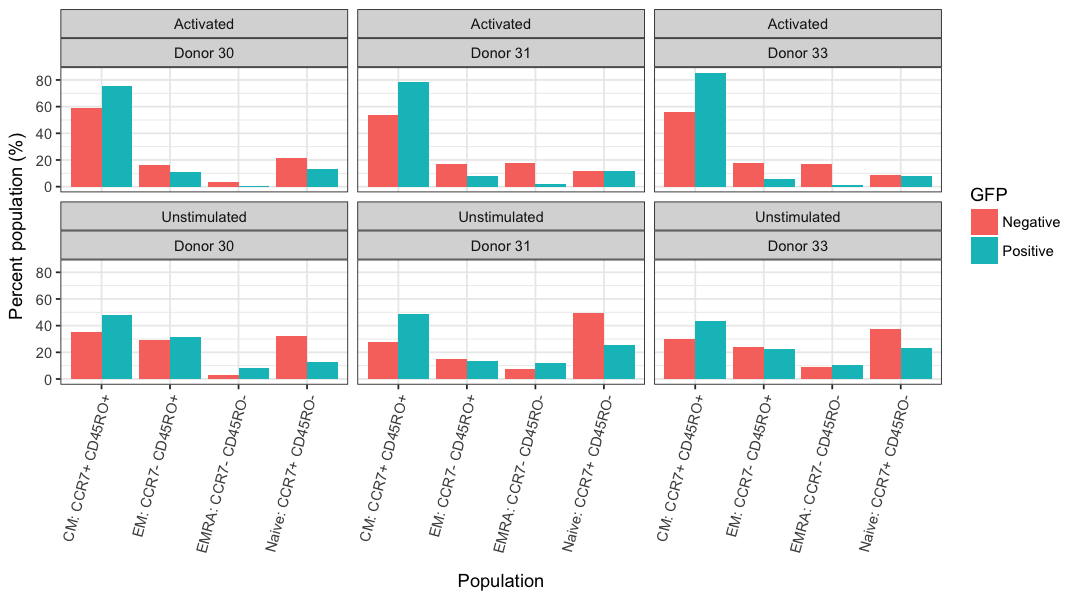

In [15]:
options(repr.plot.width=9, repr.plot.height=5)

gfp_comp_data %>%
    filter(
        `Electroporation` == "NDG plasmid",
        `Staining` == 'Naive status',
        `Population` %in% c(
            'CM: CCR7+ CD45RO+',
            'EM: CCR7- CD45RO+',
            'Naive: CCR7+ CD45RO-',
            'EMRA: CCR7- CD45RO-'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`GFP`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Cell state`+`Donor`, ncol=3) +
        ylab('Percent population (%)') +
        theme_bw() +
        theme(axis.text.x=element_text(angle=75, hjust=1))

Looks like in both the unstimulated and the activated populations, central memory cells are the ones who are getting and expressing the plasmid more compared to the rest of the other phenotypic groups.

### GFP positive vs negative -- activation status
Now let's do a similar comparison but this time for their activation status:

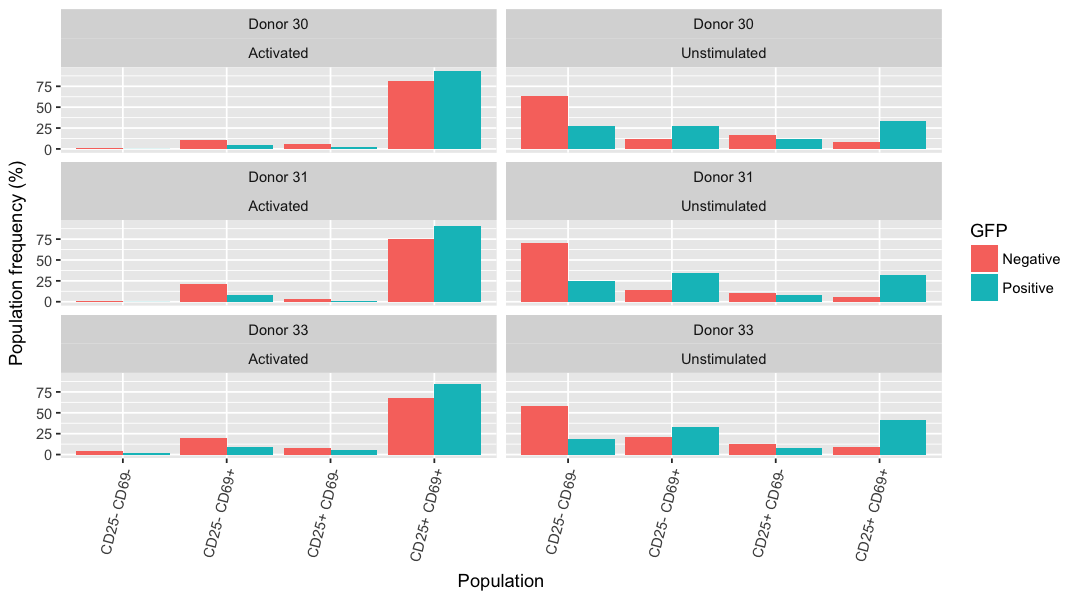

In [14]:
gfp_comp_data %>%
    filter(
        `Electroporation` == "NDG plasmid",
        `Staining` == 'Activation status',
        `Population` %in% c(
            'CD25+ CD69+',
            'CD25+ CD69-',
            'CD25- CD69+',
            'CD25- CD69-'
        )
    ) %>%
    ggplot(aes(x=`Population`, y=`Freq_of_Parent`, fill=`GFP`)) +
        geom_col(position='dodge') +
        facet_wrap(~`Donor`+`Cell state`, ncol=2) +
        ylab('Population frequency (%)') +
        theme(axis.text.x=element_text(angle=75, hjust=1))

As expected, double positive activated (i.e. `CD25+ CD69+`) cells are the ones that are more likely to be take up and express GFP. However, we see some difference in the effiency for the `CD25- CD69+` phenotype across unstimulated and activated cells.